Не забываем про описание результатов человеческим языком.

Дедлайн - 2-ое февраля

# Задание 1

Реализуйте Robust-PCA устойчивый к шуму (позволяющий восстанавливать низкоранговые матрицы даже при наличие большого шума) из статьи "Robust Principal Component Analysis" (выложено на диск - прочитайте и осознайте в чем отличие от обычного PCA!) и покажите, что ваша реализация работает.

Указания:

1. Рекомендуемый авторами алгоритм обучения представлен в секции 5
2. Проверку можно провести как в секции 4.1

**Дополнительно**: повторите эксперименты из пунктов 4.3 и 4.4 (возможно со своими данными) или придумайте (возьмите из сторонних источников) какое то другое приложение и продемонстрируйте

In [1]:
import numpy as np

class RobustPCA:
    def __init__(self, 
                 lamb=None, 
                 mu=None, 
                 tol=1e-7, 
                 max_iter=100):
        self.lamb = lamb
        self.mu = mu
        self.tol = tol
        self.max_iter = max_iter

        self.converged = None
        self.error = []
        self.L = None
        self.S = None
        self.rank = 0

    def s_tau(self, X, tau):
        return np.sign(X) * np.maximum(np.abs(X) - tau, 0)

    def d_tau(self, X):
        tau = 1.0 / self.mu

        U, s, Vt = np.linalg.svd(X, full_matrices=False)


        s_thresh = s - tau
        s_thresh = s_thresh[s_thresh > 0] 

        rank = len(s_thresh)

        X_thresh = U[:, :rank] @ np.diag(s_thresh) @ Vt[:rank, :]

        return X_thresh, rank

    def fit(self, M):
        n1, n2 = M.shape

        S = np.zeros_like(M)
        Y = np.zeros_like(M)

        if self.mu is None:
            norm1_M = np.sum(np.abs(M))
            self.mu = (n1 * n2) / (4.0 * norm1_M + 1e-16)

        if self.lamb is None:
            self.lamb = 1.0 / np.sqrt(max(n1, n2))

        for it in range(self.max_iter):
            L, rank_L = self.d_tau(M - S + (1.0 / self.mu) * Y)

            S = self.s_tau(M - L + (1.0 / self.mu) * Y, self.lamb / self.mu)
            R = M - L - S
            
            residuals_sum = np.sum(np.linalg.norm(R, 'fro')) / (np.linalg.norm(M, 'fro'))
            self.error.append(residuals_sum)
            
            if residuals_sum <= self.tol:
                break

            Y += self.mu * R

        if self.converged is None:
            if residuals_sum < self.tol:
                self.converged = True
            else:
                self.converged = False
                print("Not converged!")
                print(f"Total error: {residuals_sum}")
        else:
            print("Converged!")

        self.L, self.S, self.rank = L, S, rank_L


    def get_low_rank(self):
        return self.L

    def get_sparse(self):
        return self.S

    def get_rank(self):
        return self.rank

In [2]:
def generate_test_matrix(n, rank, sparsity):
    X = np.random.randn(n, rank) / np.sqrt(n)
    Y = np.random.randn(n, rank) / np.sqrt(n)
    L0 = np.dot(X, Y.T)

    S0 = np.zeros((n, n))
    indices = np.random.choice(np.arange(n * n), size=int(sparsity * n * n), replace=False)
    S0[np.unravel_index(indices, (n, n))] = np.random.choice([-1, 1], size=len(indices))

    M = L0 + S0
    return M, L0, S0

In [3]:
for matrix_size in [500, 1000, 2000]:
    n = matrix_size
    rank = int(0.05 * n)
    sparsity = 0.05
    
    M, L0, S0 = generate_test_matrix(n, rank, sparsity)
    
    rpca = RobustPCA()
    rpca.fit(M)
    
    L_hat = rpca.get_low_rank()
    S_hat = rpca.get_sparse()
    
    frobenius_error_L = np.linalg.norm(L0 - L_hat, 'fro') / np.linalg.norm(L0, 'fro')
    print(f"---------------------------------------------------------------------------")
    print(f"for matrix of size {n}:")
    print(f"Frobenius norm error for L0: {frobenius_error_L}")
    print(f"True rank of L0: {rank}")
    print(f"Recovered rank of L_hat: {rpca.get_rank()}")
    print(f"---------------------------------------------------------------------------")

---------------------------------------------------------------------------
for matrix of size 500:
Frobenius norm error for L0: 9.467047048166782e-07
True rank of L0: 25
Recovered rank of L_hat: 25
---------------------------------------------------------------------------
---------------------------------------------------------------------------
for matrix of size 1000:
Frobenius norm error for L0: 2.726920367868934e-06
True rank of L0: 50
Recovered rank of L_hat: 50
---------------------------------------------------------------------------
---------------------------------------------------------------------------
for matrix of size 2000:
Frobenius norm error for L0: 3.7923405484626653e-06
True rank of L0: 100
Recovered rank of L_hat: 100
---------------------------------------------------------------------------


На синтетических данных видим, что работает и получили ошибку схожую со значениями а статье

#### Доп

Проверяем работу на extended yale b dataset, как в статье, берем все картинки с одним из людей, выпрямляем, и складывам в одну матрицу

In [4]:
from imageio import imread
import matplotlib.pyplot as plt

def image_LS(image, L_image, S_image, thres=0):
    fig, ax = plt.subplots(1,4,figsize=(16,6))
    ax[0].imshow(image.astype('uint8'), cmap='gray')
    ax[0].set_title("Original image", fontsize = 16)
    ax[1].imshow(L_image.astype('uint8'), cmap='gray')
    ax[1].set_title("Low rank matrix L", fontsize = 16)
    ax[2].imshow(np.abs(S_image).astype('uint8'), cmap='gray')
    ax[2].set_title("Sparse matrix S", fontsize = 16);
    tmp = image*0.0
    tmp[(np.abs(S_image)>thres)] = image[(np.abs(S_image)>thres)]*1
    ax[3].imshow(tmp.astype('uint8'), cmap='gray')
    ax[3].set_title("Filter image pixels with S!=0", fontsize = 16)

In [5]:
from PIL import Image
import os

dataset_path = "hw_3_data/CroppedYale/yaleB01"

image_paths = [os.path.join(dataset_path, f) 
               for f in os.listdir(dataset_path) 
               if f.endswith(".pgm")]
w = 168
h = 192
image_shape = (h, w)

num_images = len(image_paths)
flattened_size = h * w
matrix = np.zeros((num_images, flattened_size), dtype=np.uint8)

for i, path in enumerate(image_paths):
    with Image.open(path) as img:
        arr = np.array(img).flatten()
        matrix[i] = arr

In [6]:
M = matrix

rpca = RobustPCA(max_iter=1000)
rpca.fit(M.astype(np.float64))

In [7]:
print(len(rpca.error))

525


Сошлось за 525 шагов

In [8]:
L_hat = rpca.get_low_rank()
S_hat = rpca.get_sparse()

num_images = matrix.shape[0]
images_M = np.zeros((num_images, h, w), dtype=np.uint8)
images_L = np.zeros((num_images, h, w), dtype=np.uint8)
images_S = np.zeros((num_images, h, w), dtype=np.uint8)

for i in range(num_images):
    images_M[i] = matrix[i].reshape((h, w))
    images_L[i] = L_hat[i].reshape((h, w))
    images_S[i] = S_hat[i].reshape((h, w))

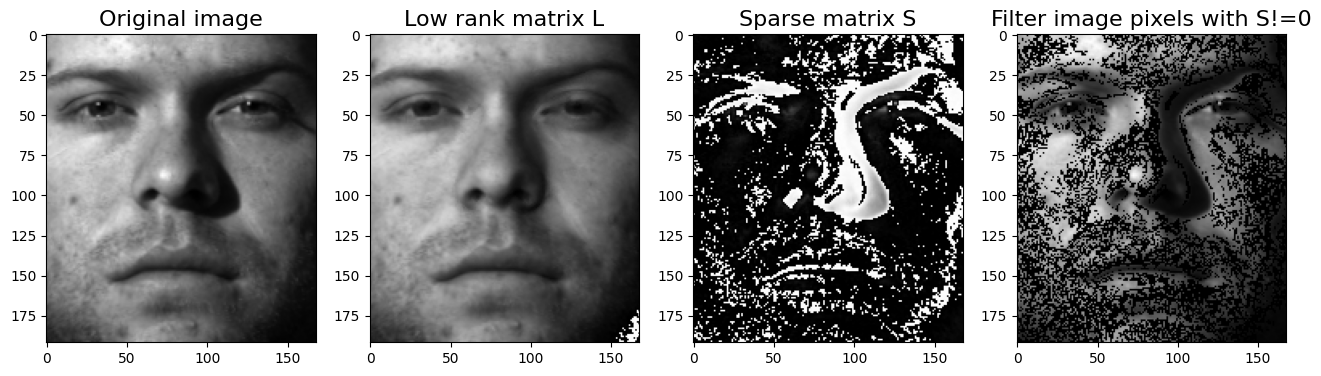

In [17]:
image_LS(images_M[15], images_L[15], images_S[15])

Видим что алгоритм очень хорошо отделяеь блики(глаза и нос), а также тени, что и ожидалось получить, теперь проверим на видео

In [10]:
import cv2
import numpy as np

def extract_frames(video_path, output_size=(168, 120), num_frames=250):
    cap = cv2.VideoCapture(video_path)
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    step = max(total_frames // num_frames, 1)
    
    frames_array = np.zeros((3, num_frames, output_size[0] * output_size[1]), dtype=np.uint8)

    frame_count = 0
    selected_frames = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        if frame_count % step == 0 and selected_frames < num_frames:
            resized_frame = cv2.resize(frame, output_size)
            
            channels = cv2.split(resized_frame)
            
            for i, channel in enumerate(channels):
                frames_array[i, selected_frames] = channel.flatten()
            
            selected_frames += 1
        
        frame_count += 1
    
    cap.release()
    
    return frames_array.T

video_path = "hw_3_data/1.mp4"
h = 120
w = 168
frames = extract_frames(video_path,  output_size=(w, h))
print(frames.shape)

(20160, 250, 3)


In [18]:
L_video = frames*0
S_video = frames*0

for i in range(3):
    rpca = RobustPCA(max_iter=300)
    rpca.fit(frames[:,:,i].astype(np.float64))
    L_video[:,:,i] = rpca.get_low_rank()
    S_video[:,:,i] = rpca.get_sparse()

Not converged!
Total error: 1.3572003570420097e-06
Not converged!
Total error: 1.3734666264101568e-06
Not converged!
Total error: 1.3692837448431877e-06


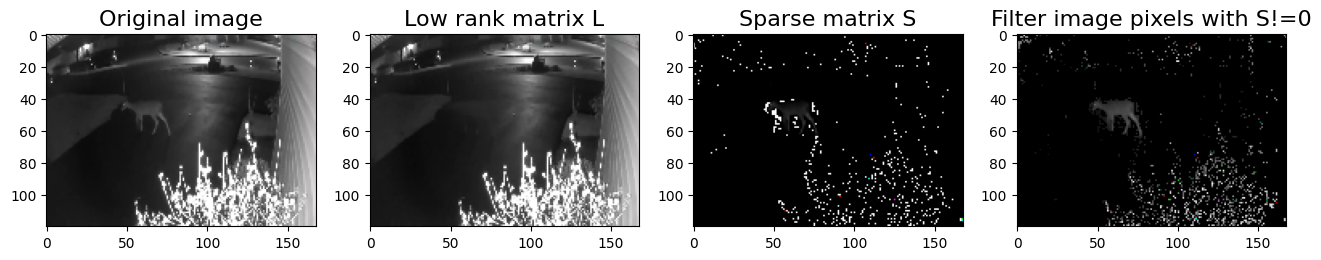

In [20]:
image_LS(frames[:,40,:].reshape(h,w,3), L_video[:,40,:].reshape(h,w,3), S_video[:,40,:].reshape(h,w,3), thres=0)

на примере с видео видим, как хорошо алгоритм отделяет оленя, эксперимент успешно повторен

# Задание 2



!!!ATTENTION: На расчеты для этого задания может уйти много времени

Основная прелесть нелинейных методов уменьшения размерности заключается в том, что нам нужна только метрика расстояния и мы можем получать эмбеддинги заданной размерности для произвольных объектов.

Возвращаемся к графам (те же данные) и ядрам из предыдущего дз. Из ядер по разному можно получить расстояние:

1. По аналогии с евклидовым расстоянием и скалярным произведением: $D_{ij} = \sqrt{K_{ii} + K_{jj} - 2K_{ij}}$
2. По аналогии с косинусным расстоянием: $D_{ij} = \arccos\left(\frac{K_{ij}}{\sqrt{K_{ii} K_{jj}}}\right)$
3. Если ядро от 0 до 1 то просто: $D_{ij} = 1 - K_{ij}$

После этого, имея расстояния, можно получать n-мерные эмбеддинги с помощью mds-like методов, а также t-sna или UMAP.

Возьмите 3 ядра и 2 метода уменьшения размерности (один -mds-like, другой - t-sna или UMAP), получите 2D эмбеддинги графов и провизуализируйте. Сделайте выводы. Постройте модели классификации.

**Дополнительно**: возьмите больше ядер и методов уменьшения размерности (4-5), комбинируйте ядра, как в прошлом дз и постарайтесь получить как можно более высокое качество классификации (можете взять больше измерений в эмбеддингах). Студенты с самым лучшим качеством получат еще доп. бал к предыдущему или следующим дз на их выбор (на усмотрение преподавателя: если у всех будет +- одинаково то доп баллов не будет).


Processing kernel: shortest_path

Distance method: euclidean


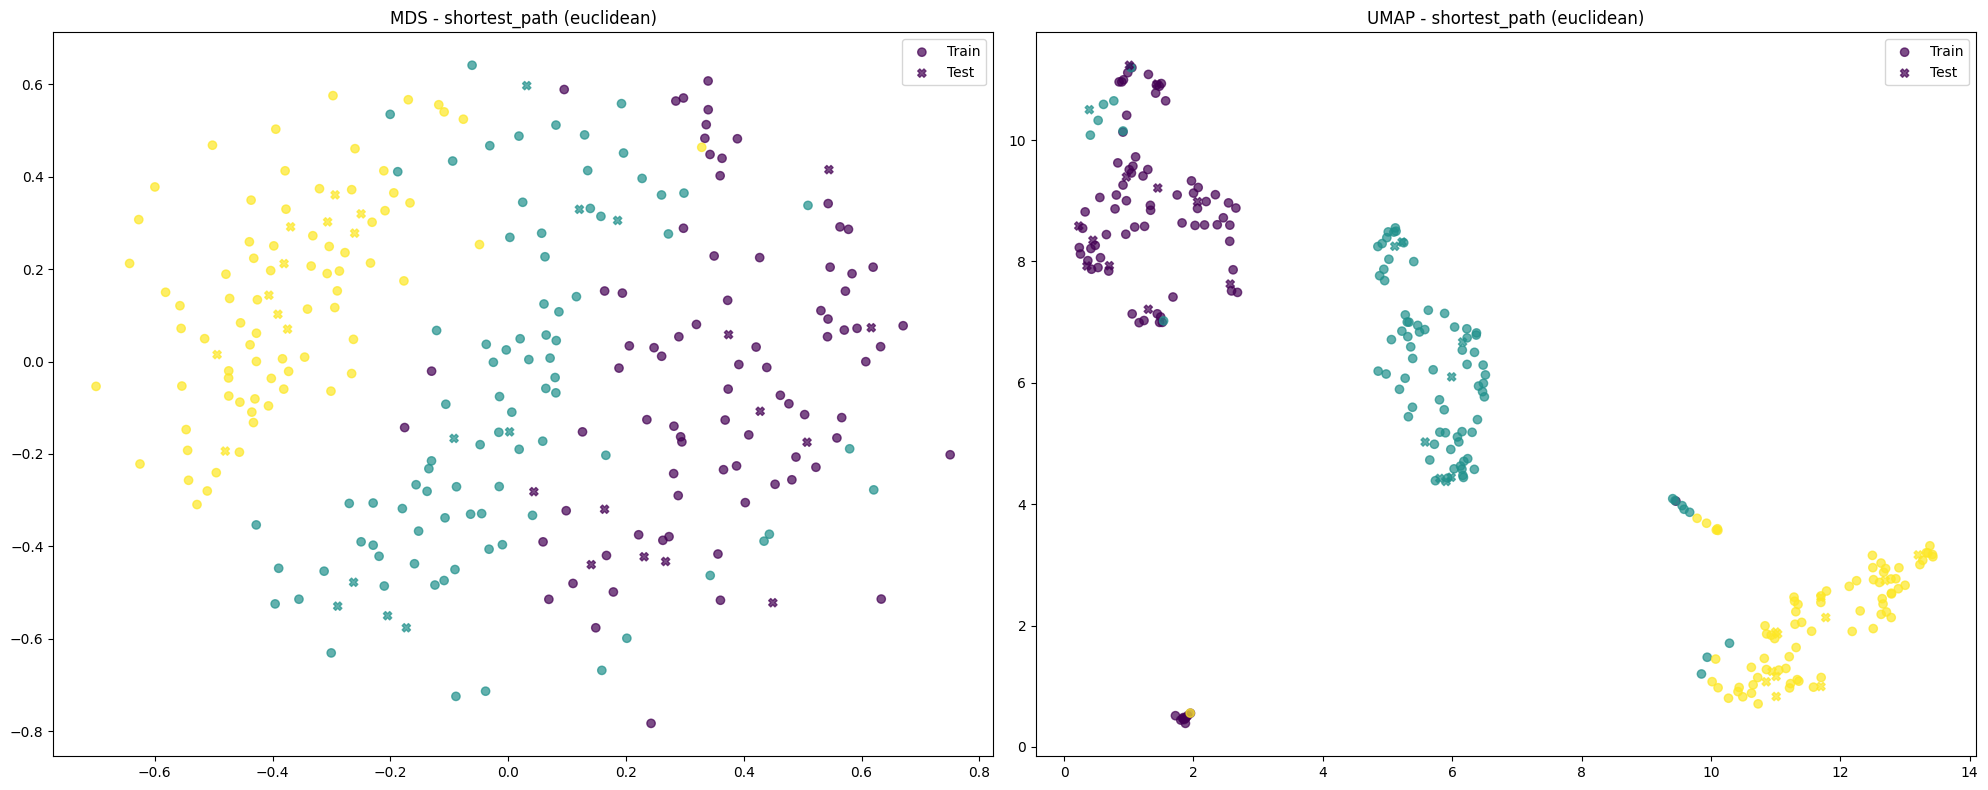

SVM | MDS Acc: 0.90 | UMAP Acc: 0.97
Ridge | MDS Acc: 0.35 | UMAP Acc: 0.61

Distance method: cosine


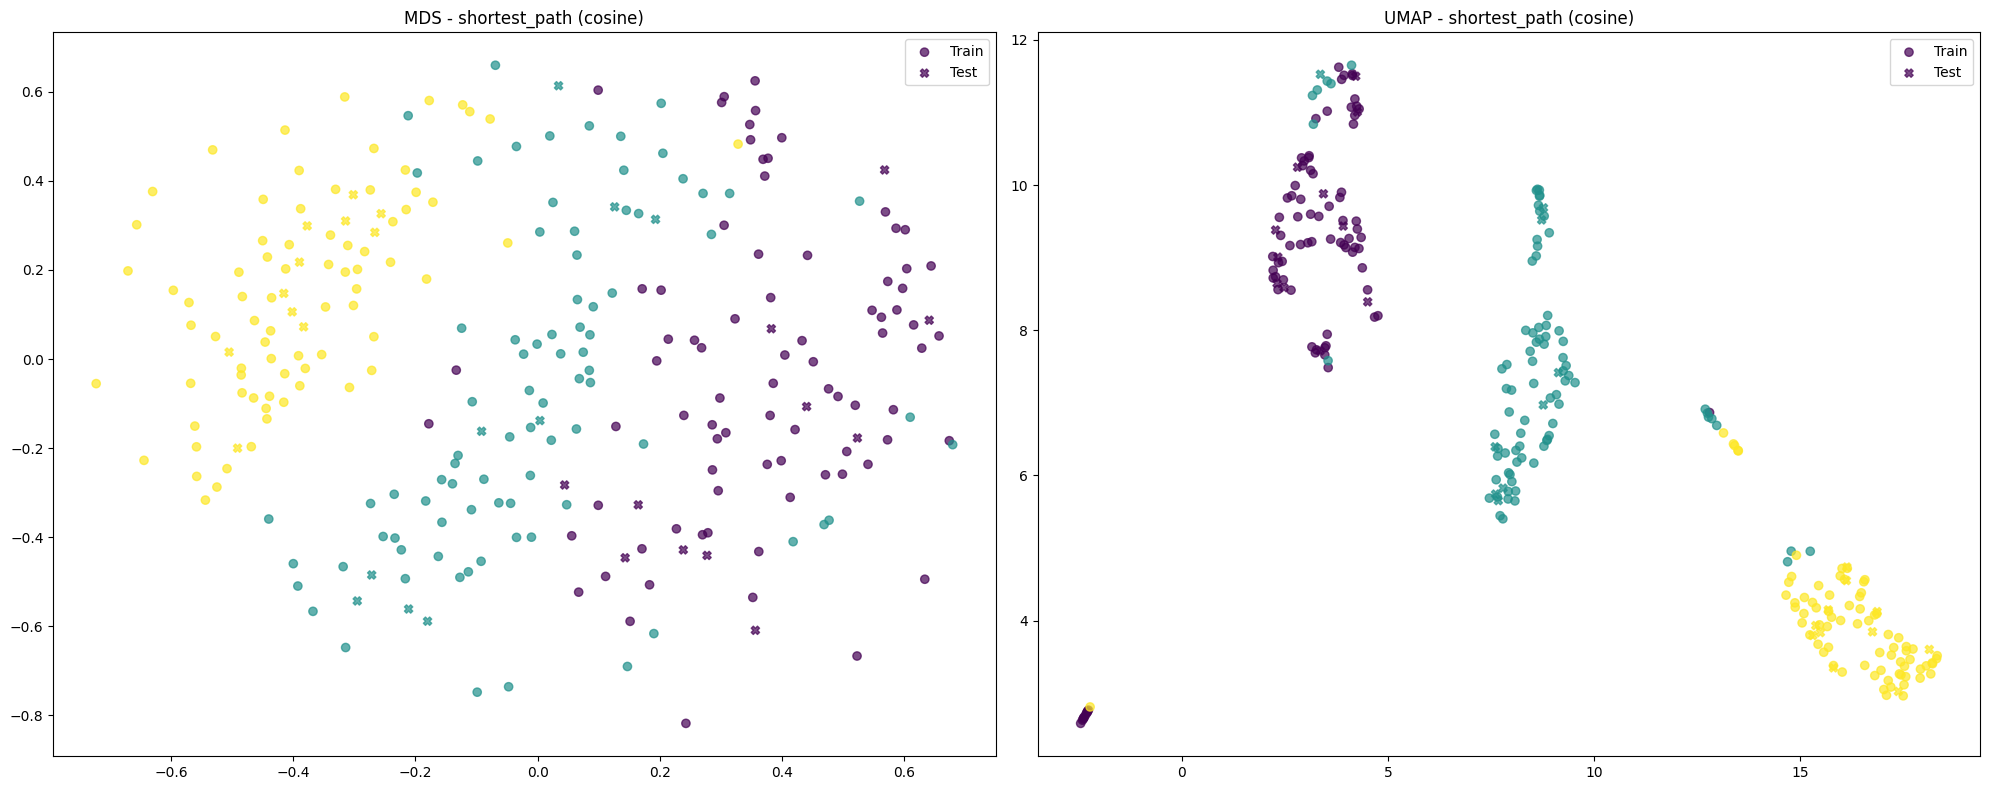

SVM | MDS Acc: 0.90 | UMAP Acc: 0.97
Ridge | MDS Acc: 0.35 | UMAP Acc: 0.61

Distance method: linear


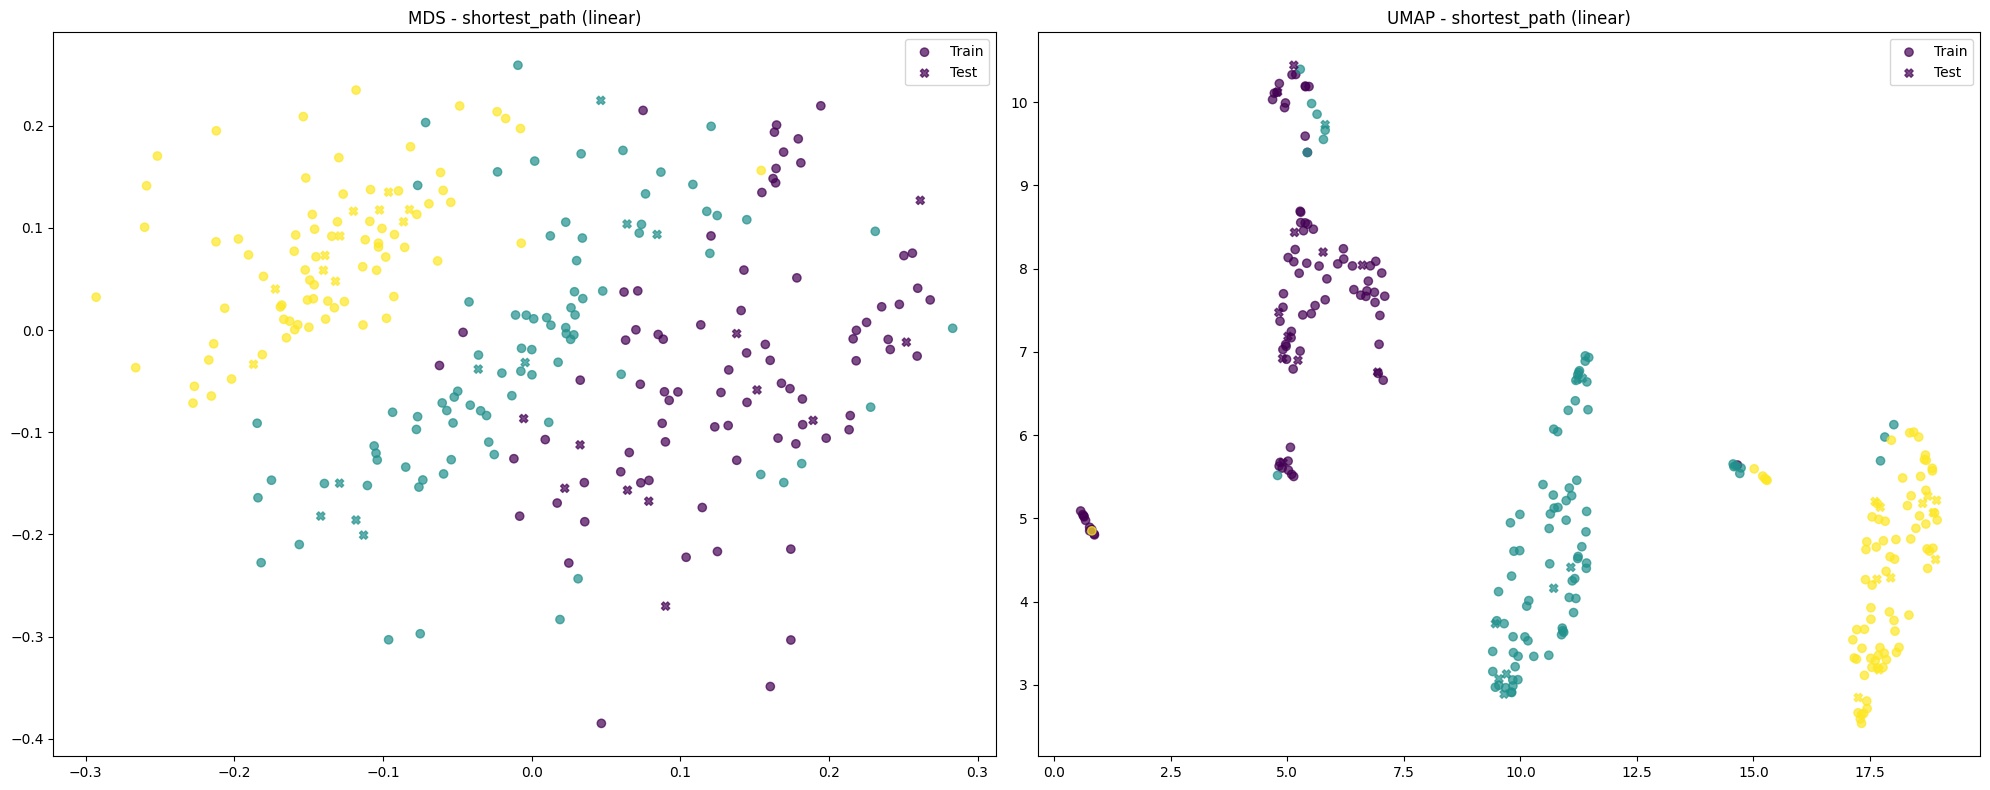

SVM | MDS Acc: 0.87 | UMAP Acc: 0.97
Ridge | MDS Acc: 0.35 | UMAP Acc: 0.61

Processing kernel: pyramid_match

Distance method: euclidean


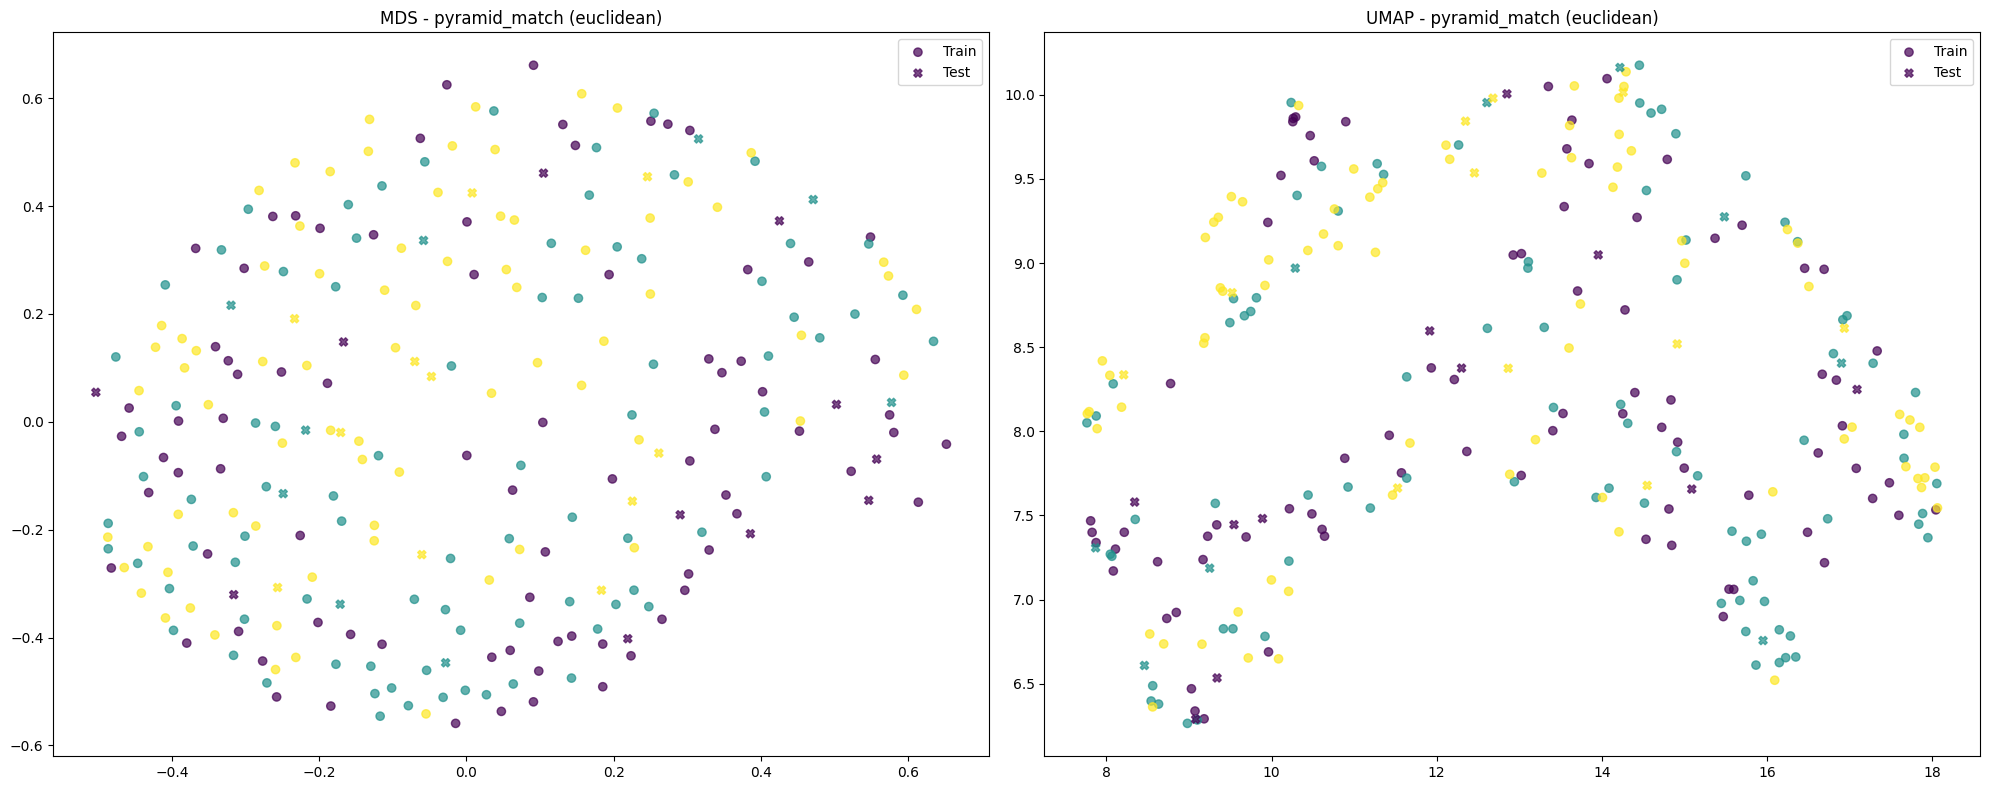

SVM | MDS Acc: 0.48 | UMAP Acc: 0.45
Ridge | MDS Acc: 0.35 | UMAP Acc: 0.29

Distance method: cosine


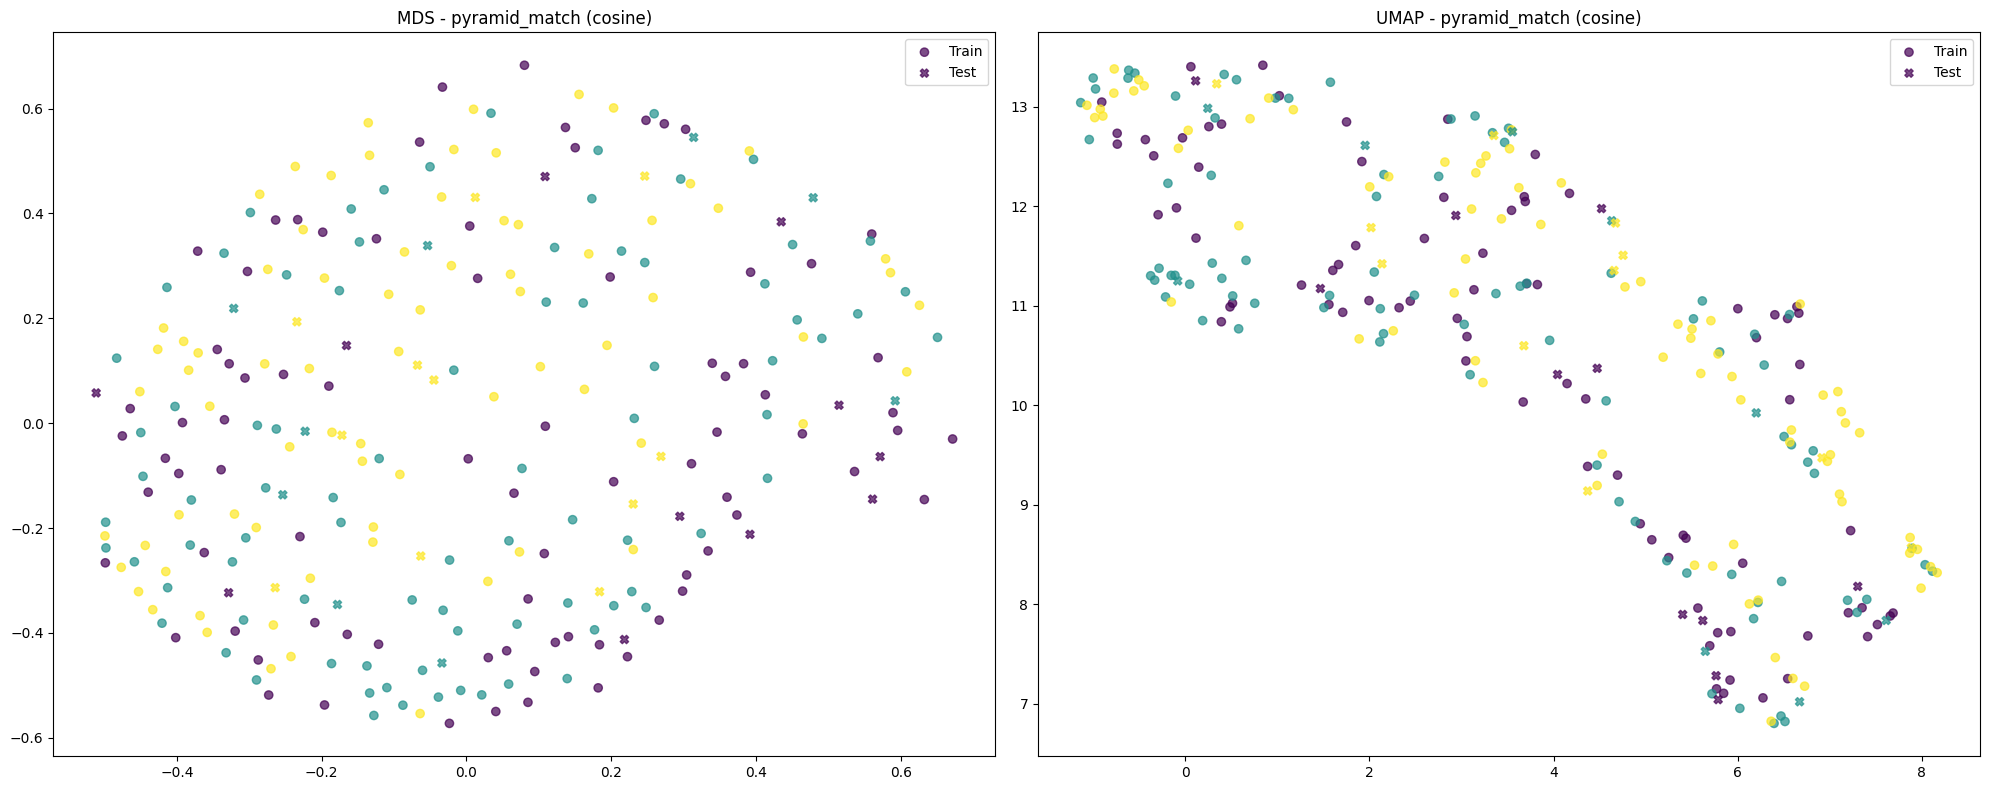

SVM | MDS Acc: 0.48 | UMAP Acc: 0.42
Ridge | MDS Acc: 0.35 | UMAP Acc: 0.29

Distance method: linear


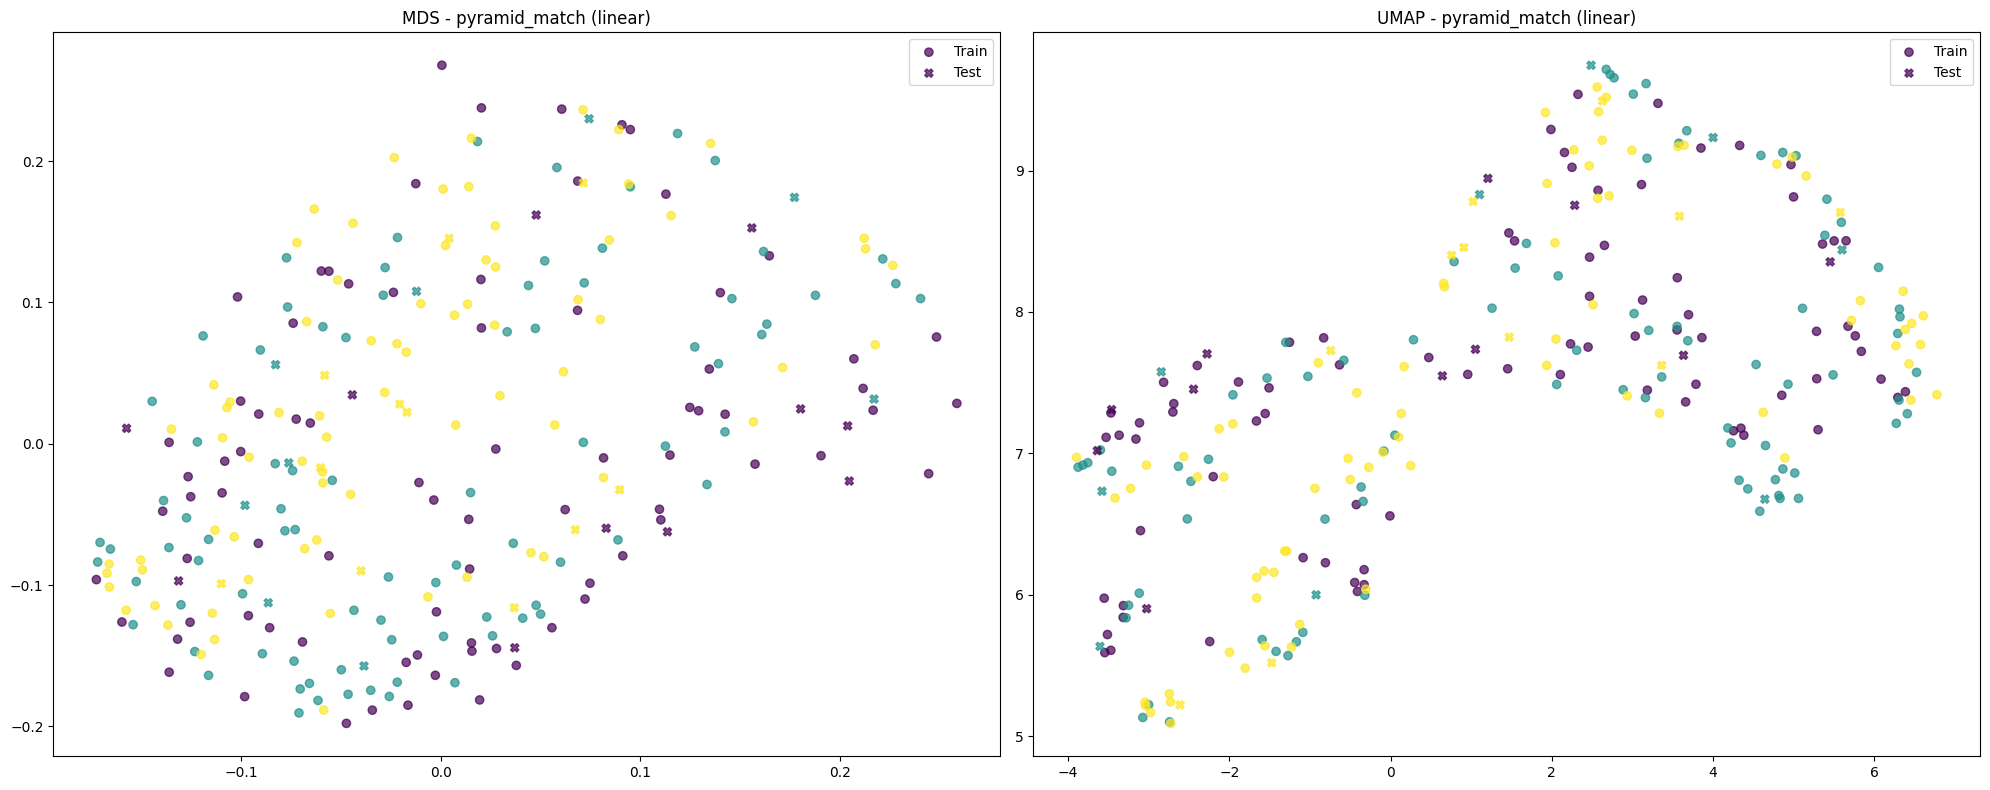

SVM | MDS Acc: 0.29 | UMAP Acc: 0.32
Ridge | MDS Acc: 0.35 | UMAP Acc: 0.29

Processing kernel: subtree_wl

Distance method: euclidean


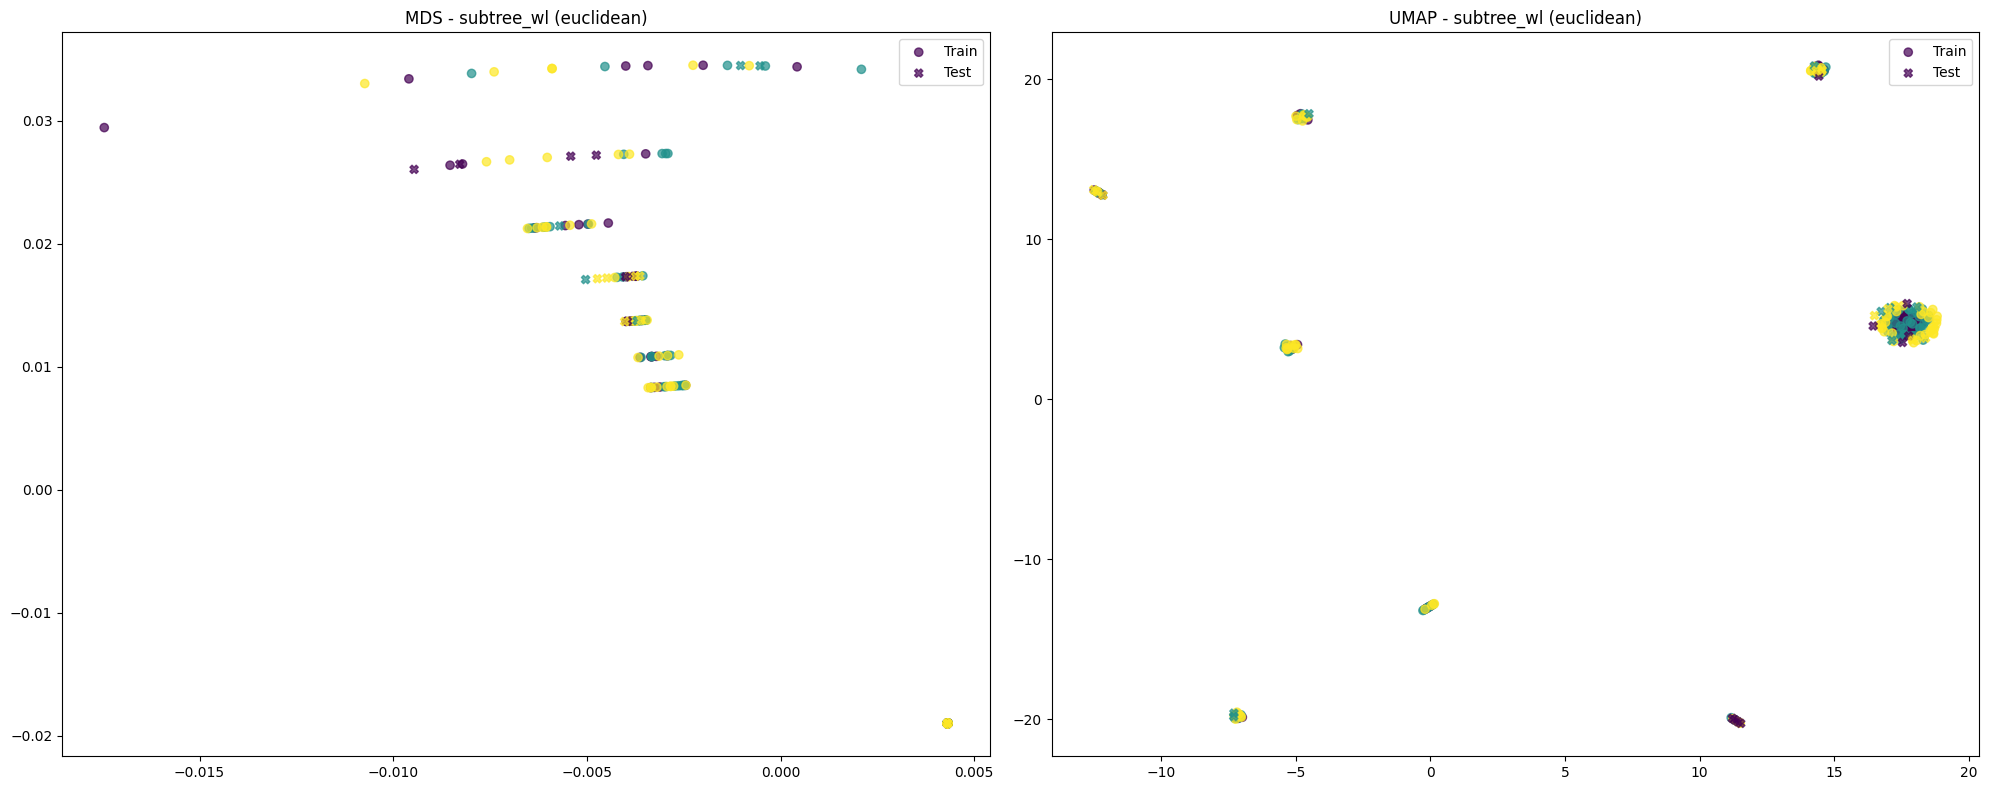

SVM | MDS Acc: 0.29 | UMAP Acc: 0.42
Ridge | MDS Acc: 0.35 | UMAP Acc: 0.35

Distance method: cosine


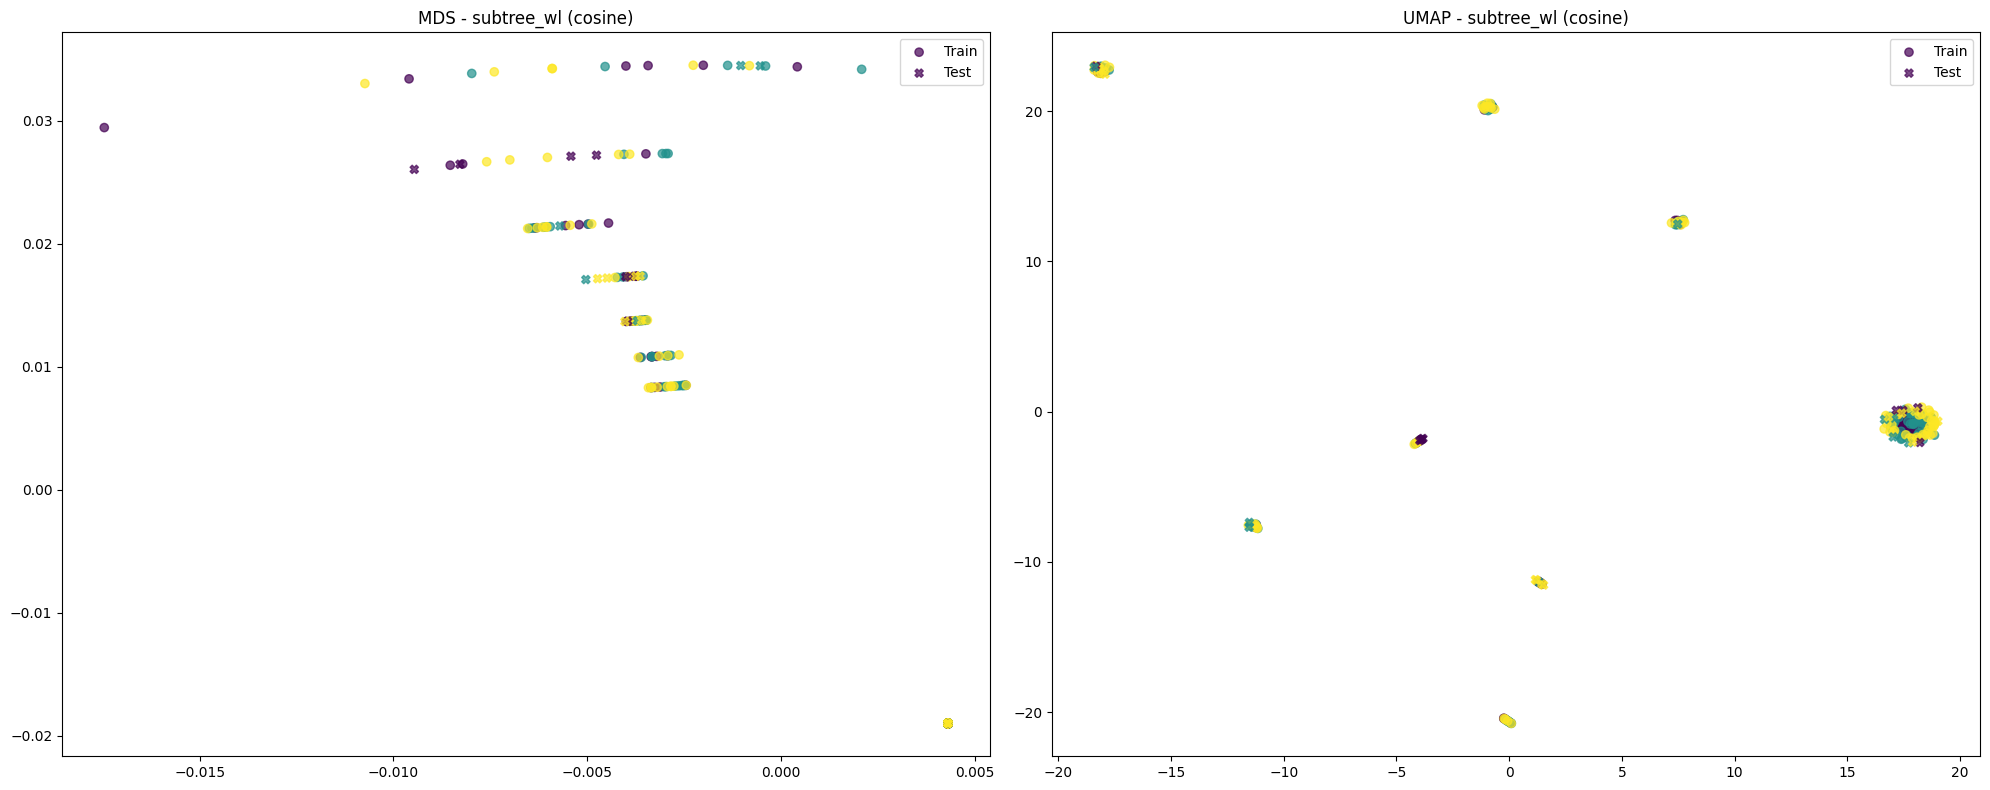

SVM | MDS Acc: 0.29 | UMAP Acc: 0.35
Ridge | MDS Acc: 0.35 | UMAP Acc: 0.39

Distance method: linear


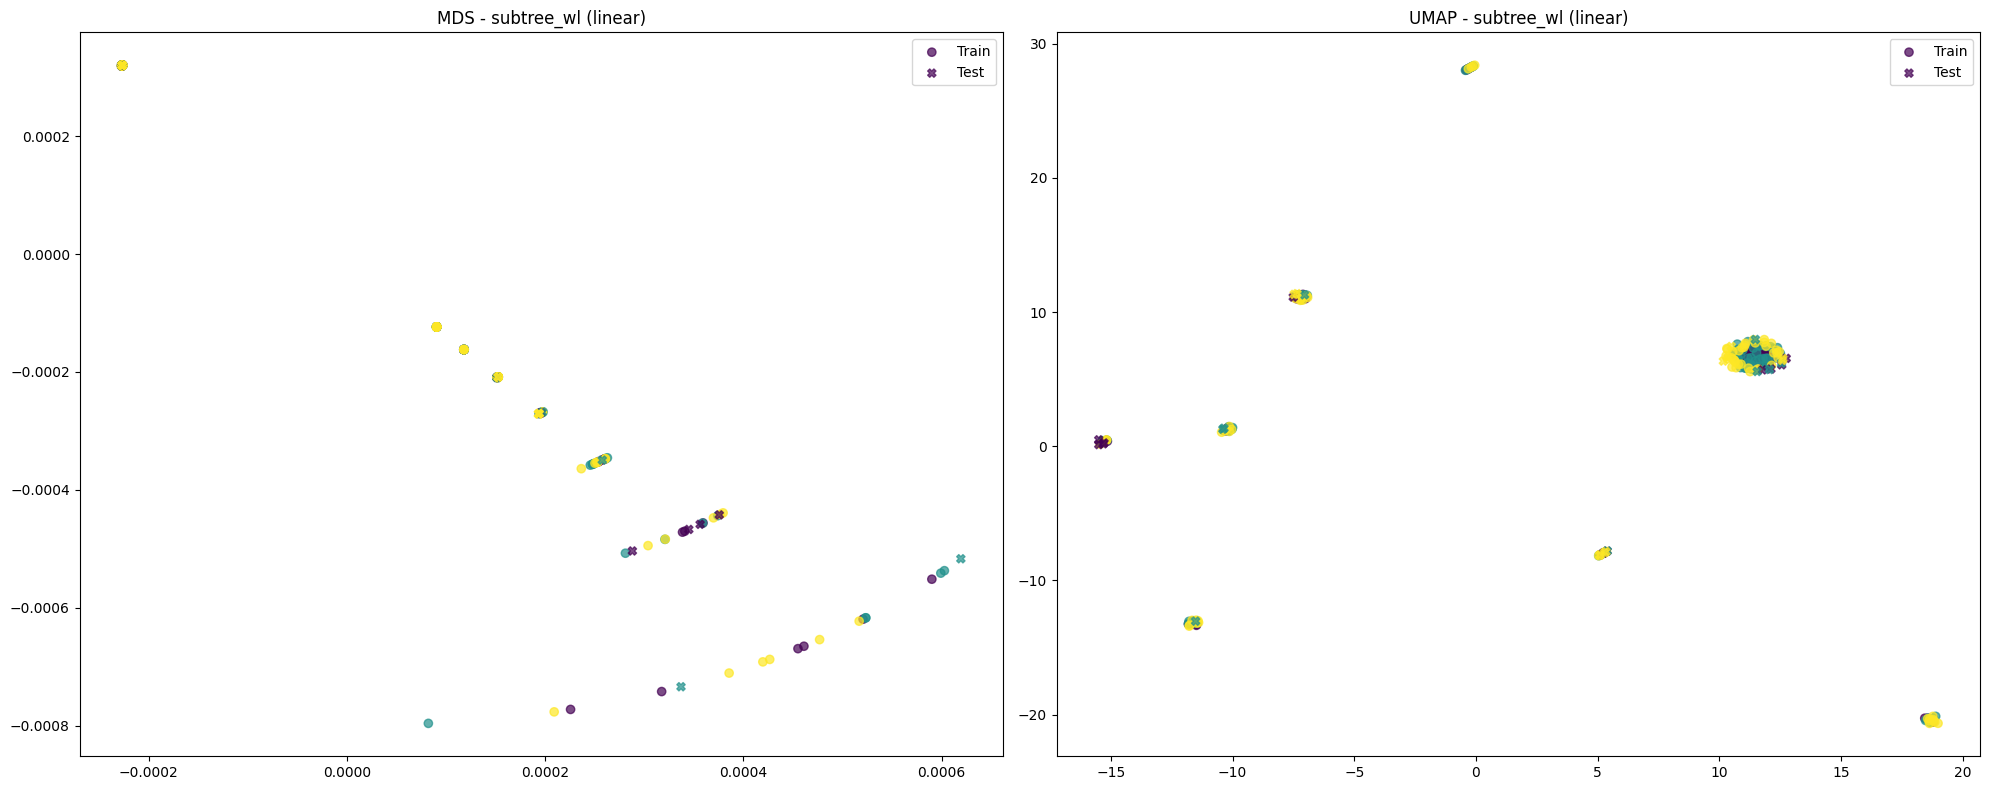

SVM | MDS Acc: 0.29 | UMAP Acc: 0.19
Ridge | MDS Acc: 0.35 | UMAP Acc: 0.35


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import umap.umap_ as umap
from sklearn.svm import SVC
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import accuracy_score
from grakel import GraphKernel, graph_from_networkx
import networkx as nx

import warnings
warnings.filterwarnings("ignore")

loaded = np.load('datasets/easy_small.npz', allow_pickle=True)
A_train = list(loaded['tr_adj'])
X_train = loaded['tr_feat']
y_train = np.argmax(loaded['tr_class'], axis=-1)
A_test = list(loaded['te_adj'])
X_test = loaded['te_feat']
y_test = np.argmax(loaded['te_class'], axis=-1)

def create_graphs(adj_list):
    return [nx.from_scipy_sparse_array(a) for a in adj_list]

G_train = create_graphs(A_train)
G_test = create_graphs(A_test)

def add_node_features(graphs, features):
    for G, x in zip(graphs, features):
        for i, feat in enumerate(x):
            G.nodes[i]['features'] = tuple(feat)
    return graphs

G_train = add_node_features(G_train, X_train)
G_test = add_node_features(G_test, X_test)

G_all = G_train + G_test
y_all = np.concatenate([y_train, y_test])

G_all_grakel = list(graph_from_networkx(G_all, node_labels_tag='features'))

kernels = ["shortest_path", "pyramid_match", "subtree_wl"]
distance_methods = ['euclidean', 'cosine', 'linear']
models = {'SVM': SVC(kernel='linear'), 'Ridge': KernelRidge(alpha=1.0, kernel='linear')}

for kernel_name in kernels:
    print(f"\n{'='*50}\nProcessing kernel: {kernel_name}\n{'='*50}")
    
    gk = GraphKernel(kernel=[{"name": kernel_name}], normalize=True)
    K_all = np.nan_to_num(gk.fit_transform(G_all_grakel))
    n = K_all.shape[0]
    
    for dist_method in distance_methods:
        print(f"\nDistance method: {dist_method}")
        
        if dist_method == 'euclidean':
            D = np.sqrt(np.maximum(
                K_all.diagonal()[:, None] + K_all.diagonal()[None, :] - 2*K_all, 
                0
            ))
        elif dist_method == 'cosine':
            norms = np.sqrt(K_all.diagonal())
            with np.errstate(divide='ignore', invalid='ignore'):
                cos_sim = K_all / np.outer(norms, norms)
            cos_sim = np.nan_to_num(cos_sim, nan=1.0)
            D = np.arccos(np.clip(cos_sim, -1, 1))
        else:
            D = 1 - K_all

        mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
        emb_mds = mds.fit_transform(D)

        umap_emb = umap.UMAP(n_components=2, metric='precomputed', random_state=42)
        emb_umap = umap_emb.fit_transform(D)

        fig, axes = plt.subplots(1, 2, figsize=(20, 8))
        methods = [('MDS', emb_mds), ('UMAP', emb_umap)]
        
        for ax, (name, emb) in zip(axes, methods):
            ax.scatter(emb[:len(y_train), 0], emb[:len(y_train), 1], 
                      c=y_train, cmap='viridis', alpha=0.7, label='Train', marker='o')
            ax.scatter(emb[len(y_train):, 0], emb[len(y_train):, 1], 
                      c=y_test, cmap='viridis', alpha=0.7, label='Test', marker='X')
            
            ax.set_title(f"{name} - {kernel_name} ({dist_method})")
            ax.legend()
        
        plt.tight_layout()
        plt.show()

        X_train_mds = emb_mds[:len(y_train)]
        X_test_mds = emb_mds[len(y_train):]
        X_train_umap = emb_umap[:len(y_train)]
        X_test_umap = emb_umap[len(y_train):]

        for model_name, model in models.items():
            # Для Ridge добавим округление
            if model_name == 'Ridge':
                def predict_wrapper(clf, X):
                    return np.clip(np.round(clf.predict(X)), 0, 1).astype(int)
            else:
                predict_wrapper = lambda clf, X: clf.predict(X)
            
            # MDS
            model.fit(X_train_mds, y_train)
            pred = predict_wrapper(model, X_test_mds)
            acc_mds = accuracy_score(y_test, pred)
            
            # UMAP
            model.fit(X_train_umap, y_train)
            pred = predict_wrapper(model, X_test_umap)
            acc_umap = accuracy_score(y_test, pred)
            
            print(f"{model_name} | MDS Acc: {acc_mds:.2f} | UMAP Acc: {acc_umap:.2f}")

сравнили три ядра, два метода уменьшения размерности и 3 вида вычисления расстояния. Наиболее интерпретируемым является ядро shortest_path, после его преобразования, в 2d пространстве разделение классов довольно сильно выделяется, с ним же получился наил